In [1]:
!pip uninstall scratchai-nightly #for adversarial attack
!pip uninstall torchvision #deep learning models
!pip uninstall flashtorch #visualization based on activation maximization 
!pip uninstall mapextrackt #visualization of neural network saliency map

Found existing installation: scratchai-nightly 0.0.1a3
Uninstalling scratchai-nightly-0.0.1a3:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/scratchai/*
    /usr/local/lib/python3.8/dist-packages/scratchai_nightly-0.0.1a3.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tests/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.8/dist-packages/tests/download_media.py
    /usr/local/lib/python3.8/dist-packages/tests/test_AudioClips.py
    /usr/local/lib/python3.8/dist-packages/tests/test_ImageSequenceClip.py
    /usr/local/lib/python3.8/dist-packages/tests/test_PR.py
    /usr/local/lib/python3.8/dist-packages/tests/test_TextClip.py
    /usr/local/lib/python3.8/dist-packages/tests/test_VideoClip.py
    /usr/local/lib/python3.8/dist-packages/tests/test_VideoFileClip.py
    /usr/local/lib/python3.8/dist-packages/tests/test_Videos.py
    /usr/local/lib/python3.8/dist-packages/tests/test_compositing.py
    /usr/local/lib/python3.8/dist-packages/tests/

In [2]:
!pip install scratchai-nightly #for adversarial attack
!pip install torchvision==0.9.1 #deep learning models
!pip install flashtorch #visualization based on activation maximization 
!pip install mapextrackt #visualization of neural network saliency map

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scratchai_nightly-0.0.1a3-py3-none-any.whl (87 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached torchvision-0.9.1-cp38-cp38-manylinux1_x86_64.whl (17.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached flashtorch-0.1.3-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mapextrackt-0.4.8.6-py3-none-any.whl (13 kB)


In [3]:
#download and store locally a stop sign image
stop_sign_url = 'https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg'
!mkdir input_images
!wget https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg -O input_images/stop.jpg

mkdir: cannot create directory ‘input_images’: File exists
--2023-02-11 03:41:02--  https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92066 (90K) [image/jpeg]
Saving to: ‘input_images/stop.jpg’

input_images/stop.j 100%[===================>]  89.91K  --.-KB/s    in 0.02s   

2023-02-11 03:41:02 (5.06 MB/s) - ‘input_images/stop.jpg’ saved [92066/92066]



In [4]:
# suppress error
import logging as logging
import sys as sys
logging.disable(sys.maxsize) 

# import the library
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from scratchai import *

from flashtorch.activmax import GradientAscent
from MapExtrackt import FeatureExtractor
from torch.distributions import Normal


# set parameters
stop_sign_path = 'input_images/stop.jpg' #stop sign image path
true_class = 919 # imagenet id for street sign


#function handle to get prediction more easily
def get_prediction(image, model):
    #assumes img and net are datasets and models trained using imagenet dataset  
    confidences = model(image.unsqueeze(0))
    class_idx = torch.argmax(confidences, dim=1).item()
    class_label = datasets.labels.imagenet_labels[class_idx]
    return class_label, confidences[0, class_idx].item(), class_idx

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


**1a: Making prediction**

In [6]:
# load and preprocess the stop sign image
img = imgutils.load_img(stop_sign_path)
img = imgutils.get_trf('rz256_cc224_tt_normimgnet')(img) #normalize and reshape the input image

# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = models.resnet18(pretrained=True).eval()  #load resnet

#use the provided get_prediction function to predict the class of the stop sign image
class_label,confidences,class_index=get_prediction(img,net)
print(f'Class Label = {class_label}')

Class Label = street sign


**1b: Random perturbation**

0.1
Class Label = street sign
Confidences = 14.593377113342285


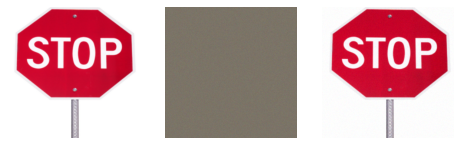

0.5
Class Label = doormat, welcome mat
Confidences = 14.955455780029297


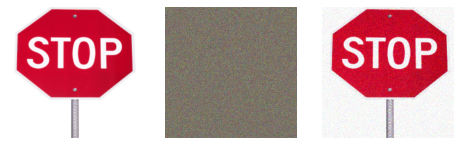

1
Class Label = doormat, welcome mat
Confidences = 16.598552703857422


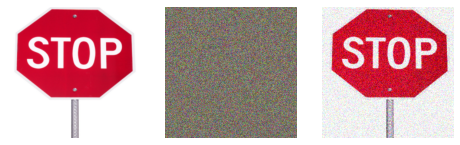

In [7]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

epsilon = [0.1,0.5,1]# set the epsilon
for i in epsilon:
  print(i)
  torch.manual_seed(0) #set the random seed when you use functions that uses sampling

  noisy_img = attacks.noise(img, eps=i) #perform uniform random attack here [see the example in the Sec. 3.2.4 of the problem set]

  ... #output prediction, conf, and label_id using get_prediction function
  class_label,confidences,class_index=get_prediction(noisy_img,net)
  print(f'Class Label = {class_label}')
  print(f'Confidences = {confidences}')

  imgutils.imshow([img, noisy_img-img, noisy_img], normd=True) #output the original image, the perturbation image, the perturbed image


As we can see that the get_predictions function is not able to correctly classify the images where the perturbations with epsilon = 0.5 and 1 is done to add noise to the image. 

**1c: FGM Attack**

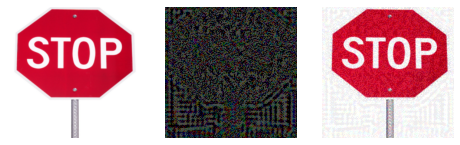

(('street sign', 13.558080673217773),
 ('doormat, welcome mat', 14.294464111328125))

In [8]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

images, true_labels, predicted_labels = one_call.attack(stop_sign_path, atk=attacks.FGM, nstr='resnet18', ret=True) #perform FGM attacks and return all the outputs

imgutils.imshow(images) #show all the images [original, perturbation, and adversarial]

true_labels, predicted_labels #show true and predicted labels

**1d: PGD Attack**

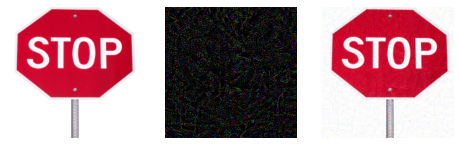

(('street sign', 13.558080673217773),
 ('streetcar, tram, tramcar, trolley, trolley car', 30.324739456176758))

In [9]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

target_class = 829 # imagenet id for street car

images, true_labels, predicted_labels = one_call.attack(stop_sign_path, y=target_class, atk=attacks.PGD, nstr='resnet18', ret=True,targeted=True) #perform PGD attacks and return all the outputs

imgutils.imshow(images) #show all the images [original, perturbation, and adversarial]

true_labels, predicted_labels #show true and predicted labels

**2a: AlexNet layer 0 visualization**

In [10]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

model = models.alexnet(pretrained=True).eval()  #load pretrained alexnet

print(model) #show the alexnet structure

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Ellipsis

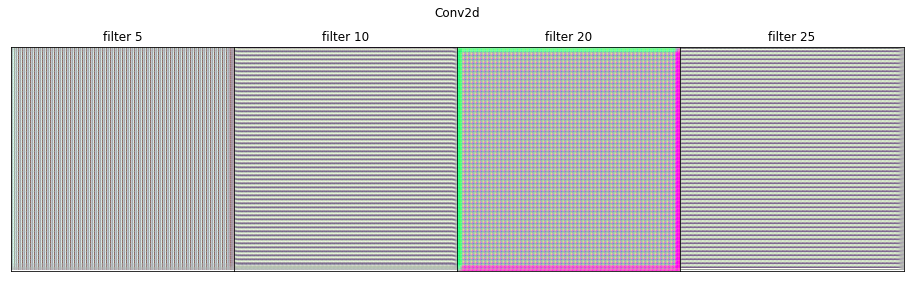

In [11]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#load GradientAscent on GPU
g_ascent = GradientAscent(model.features)
g_ascent.use_gpu = True

layer_idx = 0 #set the layer index

filters = [5,10,20,25] #set the filter numbers

layer = model.features[layer_idx] #select the 1st conv layer

g_ascent.visualize(layer, filters)
... #call g_ascent.visualize() with the correct arguments to output the visualization

**2b: AlexNet layer 10 visualization**

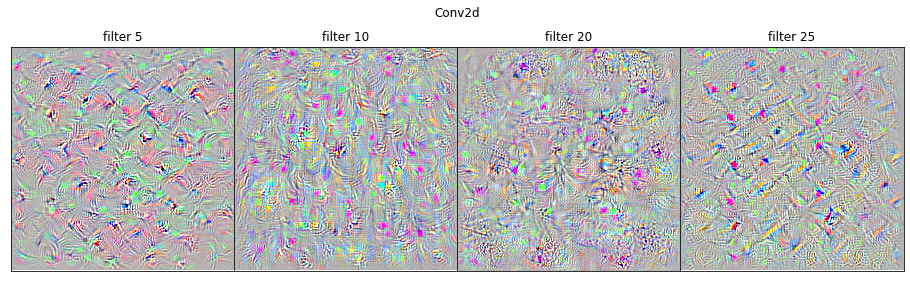

In [12]:
# MODIFY THE CODE FOR 2a TO VISUALIZE LAYER 10, FILTERS [5, 10, 15, 20] OF ALEXNET
#load GradientAscent on GPU
g_ascent = GradientAscent(model.features)
g_ascent.use_gpu = True

layer_idx = 10 #set the layer index

filters = [5,10,20,25] #set the filter numbers

layer = model.features[layer_idx] #select the 1st conv layer

g_ascent.visualize(layer, filters)

**2c: AlexNet saliency map with the stop sign image**

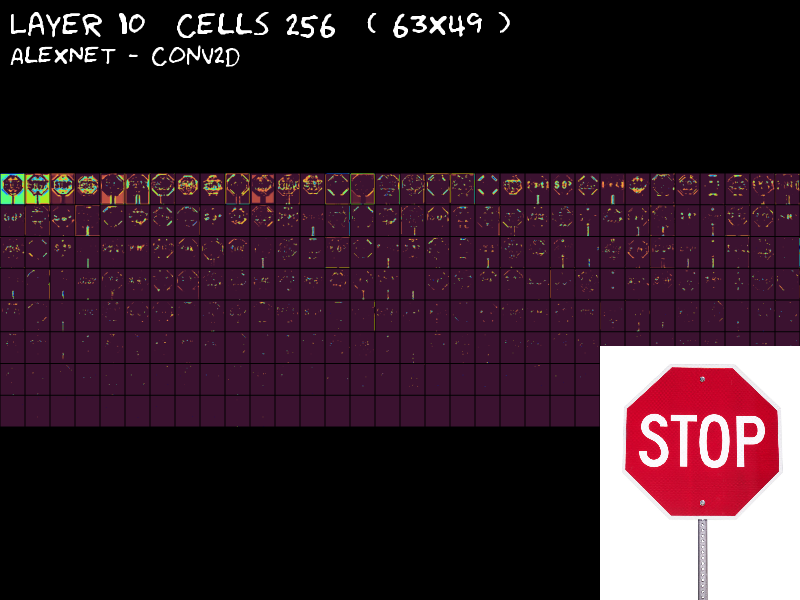

In [13]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

#load FeatureExtractor
from MapExtrackt import FeatureExtractor

layer_idx = 10 #define the layer index

fe = FeatureExtractor(model)

fe.set_image(stop_sign_path) #stop_sign_path is the path to the stop sign image

fe.display_from_map(layer_no=layer_idx)

**3: Example of plot with a confidence interval**



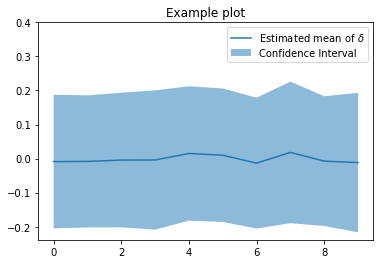

In [14]:
#THIS IS JUST AN EXAMPLE TO PLOT CONFIDENCE INTERVAL AS SHADED AREA

n = 500 # number of samples
k = 10  # number of replications
sigma = 0.2

torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(n, k)) # gaussian samples ~ N(0, sigma*I)

# compute mean and standard deviation
mean_ = deltas.mean(dim=0)
std_ = deltas.std(dim=0)

# generate the plot
x = np.arange(k) # populate x axis
plt.plot(x, mean_, label="Estimated mean of $\delta$")
plt.fill_between(x, mean_ - std_, mean_ + std_, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.4]) 
plt.title('Example plot')
plt.show()

**Density computation example with log_prob**

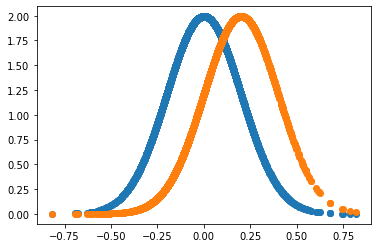

In [15]:
# THIS IS AN EXAMPLE TO USE log_prob METHOD FOR EASIER DENSITY COMPUTATION

# Suppose you want to compute the density of Normal distribution

# create Normal distribution object
p = Normal(torch.tensor([0.0]), torch.tensor([sigma])) #N(0, sigma**2)
p_tilde = Normal(torch.tensor([0.2]), torch.tensor([sigma])) #N(1, sigma**2)

# use log_prob method
log_density_orig = p.log_prob(deltas) #log_prob method gives you log densities
log_density_tilde = p_tilde.log_prob(deltas) 

# verify this by plotting the density, i.e. the exp of the log_density
plt.scatter(deltas, torch.exp(log_density_orig), label="p")
plt.scatter(deltas, torch.exp(log_density_tilde), label="p_tilde")
plt.show()

**3a: MC estimator for prob. robustness of ResNet-18**

In [16]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

net = models.resnet18(pretrained=True).eval() # load resnet

sigma = 0.2 # parameter sigma

# evaluate the model k times, each time use n samples

k = 10 # number of replications
n_list = [50,100,150,200,250,300,350,400,450,500] # number of samples in each replication

mu = []
stds = []
torch.manual_seed(0) # set the random seed

resnet_test=np.zeros([n, k])
deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(0, sigma*I)

for i in range(k):
     for j in range(n):
        noisy_img = img + deltas[:, :, :, j, i]
        _, _, y_i = get_prediction(noisy_img, net)
        resnet_test[j, i] = y_i != true_class

n_list.reverse()

for i in n_list:
  resnet_test = resnet_test[:i,:]
  mu_hat_n_samples = resnet_test.mean(axis=0)
  print(mu_hat_n_samples)
  std_ = mu_hat_n_samples.std(axis=0)
  mu.append(mu_hat_n_samples)
  stds.append(std_)

[0.03  0.038 0.046 0.038 0.028 0.036 0.04  0.024 0.026 0.032]
[0.02888889 0.04222222 0.04888889 0.03111111 0.02444444 0.03777778
 0.03555556 0.02444444 0.02       0.03555556]
[0.0275 0.035  0.0475 0.025  0.0275 0.03   0.035  0.0225 0.02   0.0325]
[0.03142857 0.03714286 0.03714286 0.02285714 0.02857143 0.03142857
 0.03714286 0.02       0.02       0.03428571]
[0.03333333 0.04333333 0.03666667 0.01666667 0.03       0.03333333
 0.03666667 0.02333333 0.02       0.03333333]
[0.04  0.044 0.044 0.016 0.032 0.028 0.036 0.02  0.024 0.036]
[0.045 0.055 0.055 0.02  0.035 0.03  0.045 0.025 0.015 0.03 ]
[0.04666667 0.02666667 0.06       0.01333333 0.04666667 0.04
 0.06       0.02666667 0.02       0.04      ]
[0.06 0.03 0.05 0.01 0.04 0.04 0.06 0.03 0.03 0.03]
[0.06 0.02 0.04 0.02 0.04 0.06 0.1  0.06 0.   0.02]


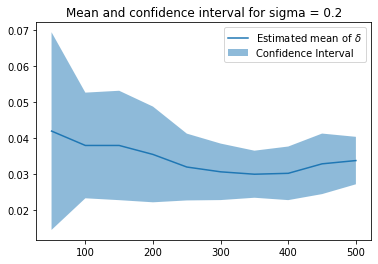

In [17]:
std_std = np.array(stds)
mu_3a = np.array(mu).mean(axis=1)
x = n_list # populate x axis
plt.plot(x, mu_3a, label="Estimated mean of $\delta$")
plt.fill_between(x, mu_3a - std_std, mu_3a + std_std, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.title('Mean and confidence interval for sigma = 0.2')
plt.show()

**3b: MC relative error**

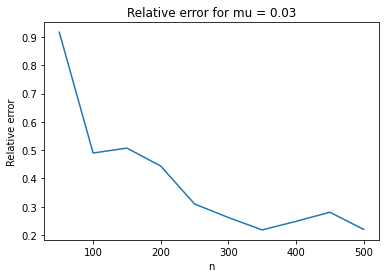

In [18]:
mu = 0.03 #true mu value
relative_error = std_std/mu # compute the relative error

# PLOT THE RELATIVE ERROR VS n
plt.plot(x,relative_error)
plt.title('Relative error for mu = 0.03')
plt.xlabel('n')
plt.ylabel('Relative error')
plt.show()


**3c: Misclassification rate w.r.t. samples close to an adversarial example**

In [19]:
# REPLACE THE THREE DOTS WITH YOUR OWN CODE

# repeat the FGM attack from problem 1c
xtilde = one_call.attack(stop_sign_path, atk=attacks.FGM, nstr="resnet18", ret=True)[0][-1]
# imgutils.imshow(xtilde)
# perform mean shift, closer to the adversarial example
scale = 1/3
mean_shift = scale*xtilde

# generate Gaussian samples centered at the mean_shift
torch.manual_seed(0) # set the random seed

sigma = 0.2 # parameter sigma

# evaluate the model k times, each time use n samples
k = 10 # number of replications
n = 500 #as per suggestion on campuswire
n_list = [50,100,150,200,250,300,350,400,450,500] # number of samples in each replication

mu = []
std = []

torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(*img.shape, n, k)) # gaussian samples ~ N(0, sigma*I)

resnet_test = np.zeros([n, k])

for i in range(k):
    for j in range(n):
      deltas[:, :, :, j, i] = deltas[:, :, :, j, i] + mean_shift

      noisy_img = img + deltas[:, :, :, j, i]
      _, _, y_i = get_prediction(noisy_img, net)
      resnet_test[j, i] = y_i != true_class
n_list.reverse()   
for n in n_list:
  mu_hat_n_samples = resnet_test[:n,:].mean(axis=0)

  mean_ = mu_hat_n_samples.mean()
  std_ = mu_hat_n_samples.std()

  mu.append(mean_)
  std.append(std_)



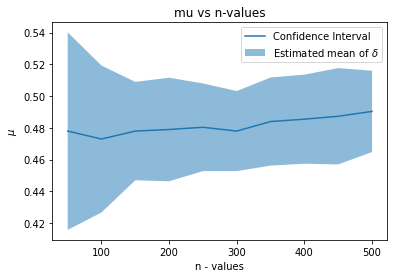

In [20]:
# compute misclassification rate using this new deltas, similar to 3a above
std_std = np.array(stds)
mu_3c = np.array(mu).mean(axis=1)

x = n_list
plt.plot(x, mu_3c, label="Confidence Interval")
plt.fill_between(x, mu_3c - std_std, mu_3c - std_std, alpha=0.5,label="Estimated mean of $\delta$" ) # 1-sigma confidence interval
plt.legend()
plt.title("mu vs n-values")
plt.xlabel("n - values")
plt.ylabel("$\mu$")
plt.show()

**3d: IS estimator**

In [21]:
n = 500
resnet_test=np.zeros([n, k])
torch.manual_seed(0) # set the random seed
for i in range(k):
    for j in range(n):
      p = Normal(torch.tensor([0.0]), torch.tensor([sigma]))
      log_density_p = p.log_prob(deltas[:, :, :, j, i])
      log_density_ptilde = p.log_prob(deltas[:, :, :, j, i] - mean_shift) 
      lkl_ratio = torch.exp(log_density_p.sum() - log_density_ptilde.sum())
      deltas[:, :, :, j, i] = deltas[:, :, :, j, i] - mean_shift
      noisy_img = (img + deltas[:, :, :, j, i])
      _, _, y_i = get_prediction(noisy_img, net)
      resnet_test[j, i] = y_i != true_class
      resnet_test[j, i] = resnet_test[j, i] * lkl_ratio

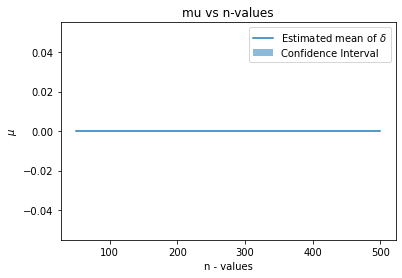

In [22]:
mu = []
std = []
for n in n_list:
  mu_hat_n_samples = resnet_test[:n,:].mean(axis=0)
  mean_ = mu_hat_n_samples.mean()
  std_ = mu_hat_n_samples.std()
  mu.append(mean_)
  std.append(std_)
mu_3d = np.array(mu)
std_std = np.array(std)
# plot the mean and the confidence interval of mu_hat_n vs n
plt.plot(x, mu_3d, label="Estimated mean of $\delta$")
plt.fill_between(x, mu_3d - std_std, mu_3d + std_std, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.title("mu vs n-values")
plt.xlabel("n - values")
plt.ylabel("$\mu$")
plt.show()

**3e: IS relative error**

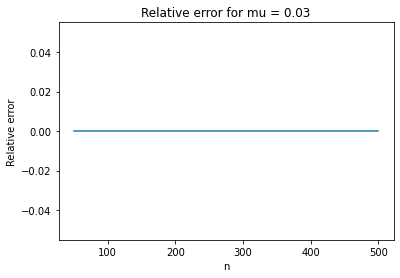

In [23]:
#similar to 3b, but use the IS result

mu = 0.03 #true mu value
relative_error = std_std/mu # compute the relative error
# PLOT THE RELATIVE ERROR VS n
plt.plot(n_list,relative_error)
plt.title('Relative error for mu = 0.03')
plt.xlabel('n')
plt.ylabel('Relative error')
plt.show()

Here we can see that the mean of the MC sampling starts to converge to the true mean as the number of samples increase but that is not the case with the IS, as the mean in IS stays close to 0. This can be because in the IS, the weighing function is of utmost importance and it should be chosen well inorder to get the importance correct. The IS is sensitive to the choice of weighing function. Here I believe the weighing function is not choosen close to the targeted distribuion becuase of which the mean does not converge to the true mean value even when the number of samples increase.

Hence in this scenario **Monte Carlo Sampling is better than Importance Sampling.**